In [1]:
import networkx as nx
from networkx.generators.random_graphs import _random_subset
import sympy as sp
from sympy import symbols 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sympy.utilities.lambdify import lambdify


import copy
import time
import random as rd

In [2]:
# G = nx.read_adjlist("BA.adjlist")
# G = nx.read_adjlist("ER.adjlist")
G = nx.read_adjlist("CO.adjlist")

nodes = sorted([int(n) for n in G.nodes])

In [3]:
N = len(G.nodes)

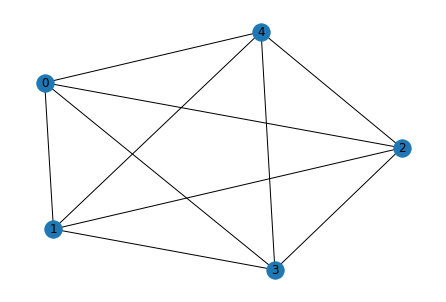

In [4]:
nx.draw(G, with_labels=True)    
plt.show()

In [5]:
adjacency = list(G.adjacency())

In [6]:
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)]

for a, b in adjacency :
    a = int(a)
    for c in b :
        c = int(c)
        A[a][c] = 1

In [7]:
seed = np.random.RandomState()
def dynamic_evolution(G, history = []):
    evolution = [0] * len(G.nodes)
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neighbours = list(G[n])
            new_node = _random_subset(neighbours, 1, seed).pop()
            evolution[int(new_node)] += 1
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[int(n)]
    history += [evolution]

In [8]:
walker_per_node = 10000

In [9]:
long_history = [[]]
for h in range(len(long_history)):
    long_history[h] = [[walker_per_node] * len(G.nodes)]

In [10]:
time_steps = int(5e2)

In [11]:
t0 = time.time()

for h in range(len(long_history)):
    for n in G.nodes:
        G.nodes[n]['N_i'] = walker_per_node
    
    for t in range(time_steps):
        dynamic_evolution(G, long_history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 4 minutes and 40.13458466529846 seconds


In [12]:
index = []
for i in range(N):
    for j in range(i+1, N):
        if A[i][j] == 1:
            index += [(i,j)]

removed_link = index[rd.randint(0, len(index)-1)]
links = len(index) - 1

G.remove_edge(str(removed_link[0]), str(removed_link[1]))

In [13]:
print("It was removed the link between node", removed_link[0], "and node", removed_link[1])

It was removed the link between node 0 and node 3


In [14]:
A[removed_link[0]][removed_link[1]] = 0
A[removed_link[1]][removed_link[0]] = 0

In [15]:
adjacency = list(G.adjacency())
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)]

for a, b in adjacency :
    a = int(a)
    for c in b :
        c = int(c)
        A[a][c] = 1
        
P = []
for a, b in adjacency :
    P += [[0]*len(adjacency)]
    
for a, b in adjacency :
    a = int(a)
    for c in b: 
        c = int(c)
        P[a][c] = 1./G.degree[str(a)]

matrixP = np.array(P)
autovaloriP, autovettoriP = np.linalg.eig(np.transpose(matrixP))
autovettoriP = np.transpose(autovettoriP)

diff = [np.abs(autovaloriP[i] - 1) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriP[i] - 1) == minDiff:
        pS2 = autovettoriP[i]
        print("Eigenvector found")
        break

if pS2[0] < 0:
    pS2 = -pS2

print('Autovalori di P:', autovaloriP)

matrixL = np.identity(N) - matrixP

autovaloriL, autovettoriL = np.linalg.eig(np.transpose(matrixL))
autovettoriL = np.transpose(autovettoriL)

diff = [np.abs(autovaloriL[i]) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriL[i]) == minDiff:
        pS2_L = autovettoriL[i]
        print("Eigenvector found")
        break

if pS2_L[0] < 0:
    pS2_L = -pS2_L

print('Autovalori di L:', autovaloriL)

Eigenvector found
Autovalori di P: [ 1.00000000e+00  4.41050056e-17 -5.00000000e-01 -2.50000000e-01
 -2.50000000e-01]
Eigenvector found
Autovalori di L: [0.   1.   1.5  1.25 1.25]


In [16]:
i = 13
print(np.round(pS2, i) == np.round(pS2_L, i))

pS2  = np.round(pS2.real, i)

[ True  True  True  True  True]
[0.36927447 0.49236596 0.49236596 0.36927447 0.49236596]


In [17]:
t0 = time.time()

for h in range(len(long_history)):    
    for t in range(time_steps):
        dynamic_evolution(G, long_history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 4 minutes and 34.97168302536011 seconds


In [18]:
W = symbols(f'w:{links}')
print("There are", links, "indipendent weights")

There are 9 indipendent weights


In [19]:
count = 0
P = copy.deepcopy(A)
for i in range(N):
    for j in range(i+1, N):
        if P[i][j] == 1:
            P[i][j] = W[count]
            P[j][i] = W[count]
            count += 1

2* L'autovettore stazionario non coincide

In [20]:
# with open("BA-pS.txt", "r") as file:
# with open("ER-pS.txt", "r") as file:
with open("CO-pS.txt", "r") as file:
    pS = file.read()
    pS = pS.split("\n")
    
pS = [float(i) for i in pS[:-1]]
pS = np.round(pS, 5)

In [21]:
e = (np.dot(pS, P) - pS)**2
E = e[0]
for i in range(1, len(e)):
    E += e[i]

1* Aggiungere la normalizzazione dei pesi alla funzione di costo fa ottenere molti autovettori vicini a 1 e l'autovettore stazionario non coincide con il valore atteso.

In [22]:
t0 = time.time()

my_func = lambdify(W, E)

def my_func_v(x):
    return my_func(*tuple(x))

# def cons1(x, i):
#     C = (sum(P[i])-1)**2
#     func = lambdify(W, C)
#     return func(*tuple(x))

# cons = ([{'type' : 'eq', 'fun': lambda x: cons1(x, i)} for i in range(len(P))])

x0 = [1/links]*links
# solution = minimize(my_func_v, x0, bounds = [[0, np.inf]]*len(x0), constraints=cons).x
result = minimize(my_func_v, x0, bounds = [[0, np.inf]]*len(x0), tol = 1e-15)
solution = result.x

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 0.028995990753173828 seconds


In [23]:
count = 0
P_new = copy.deepcopy(A)
for i in range(N):
    for j in range(i+1, N):
        if P_new[i][j] == 1:
            P_new[i][j] = solution[count]
            P_new[j][i] = solution[count]
            count += 1

2* l'autovettore stazionario non coincide con quello atteso

In [24]:
matrixP = np.array(P_new)

In [25]:
autovaloriP, autovettoriP = np.linalg.eig(np.transpose(matrixP))
autovettoriP = np.transpose(autovettoriP)

In [26]:
diff = [np.abs(autovaloriP[i] - 1) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriP[i] - 1) == minDiff:
        pS_new = autovettoriP[i]
        print("Eigenvector found")
        break

np.round(autovaloriP.real, 4)

Eigenvector found


array([ 1.    , -0.6667,  0.    , -0.1667, -0.1667])

In [27]:
if pS_new[0] < 0:
    pS_new = -pS_new

In [28]:
pS_new = pS_new.real

In [29]:
for i in range(4):
    print(sum(P_new[i]))

1.0000000000119544
0.9999999961092656
0.9999999989971734
0.9999999899880464


In [30]:
seed = np.random.RandomState()
def dynamic_evolution_after(G, P_new, history = []):
    evolution = [0]*N
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neightbours = []
            n = int(n)
            for ind in range(len(P_new)):
                if P_new[n][ind] != 0:
                    if len(neightbours) != 0:
                        neightbours += [[ind, P_new[n][ind] + neightbours[-1][1]]]
                    else:
                        neightbours = [[ind, P_new[n][ind]]]
            s = sum(P_new[n])
            prob = rd.uniform(0., s)

            for neigh, p in neightbours:
                if prob <= p:
                    evolution[neigh] += 1
                    break
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[int(n)]
    history += [evolution]

In [31]:
history = [[], [], []]
for h in range(len(history)):
    history[h] = [[walker_per_node] * len(G.nodes)]

In [32]:
t0 = time.time()

for h in range(len(long_history)):
    h = int(h)
    for t in range(time_steps):
        dynamic_evolution_after(G, P_new, long_history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 1 minutes and 9.9878990650177 seconds


In [33]:
time_steps = int(5e2)

In [34]:
t0 = time.time()

for h in range(len(history)):
    h = int(h)
    for n in G.nodes:
        G.nodes[n]['N_i'] = walker_per_node
    
    for t in range(time_steps):
        dynamic_evolution_after(G, P_new, history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 3 minutes and 20.024884700775146 seconds


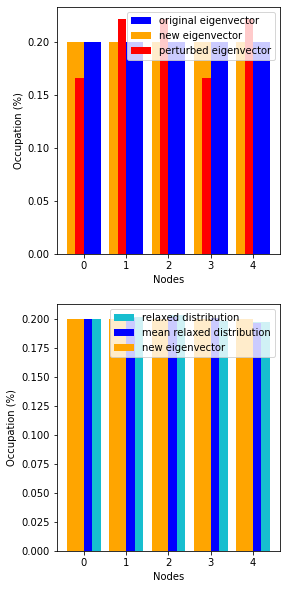

Solution found minimizing 5 equation in 9 variables


In [35]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(0.8*N, 10))

pSNorm = [h/sum(pS) for h in pS]
pS2Norm = [h/sum(pS2) for h in pS2]
pSNorm_new = [h/sum(abs(pS_new)) for h in pS_new]

ax[0].bar(nodes, pSNorm, width=0.4, align='edge', color='blue', label="original eigenvector")
ax[0].bar(nodes, pSNorm_new, width=-0.4, align='edge', color='orange', label="new eigenvector")
ax[0].bar(nodes, pS2Norm, width=-0.2, align='edge', color='red', label="perturbed eigenvector")

hMean = [[(h1+h2+h3)/walker_per_node/N/3 
          for h1, h2, h3 in zip(history[0][i], history[1][i], history[2][i])] 
         for i in range(len(history[0]))]

ax[1].bar(nodes, [h/sum(history[0][-1]) for h in history[0][-1]], width=0.4, 
          align='edge', color='tab:cyan', label='relaxed distribution')
ax[1].bar(nodes, hMean[-1], width=0.2, align='edge', color='blue', label='mean relaxed distribution')
ax[1].bar(nodes, pSNorm_new, width=-0.4, align='edge', color='orange', label="new eigenvector")

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlabel("Nodes")
    ax[i].set_ylabel("Occupation (%)")
    ax[i].set_xticks(np.arange(0, N, 1))
#     ax[i].grid(True)

plt.show()

print(f"Solution found minimizing {N} equation in {links} variables")

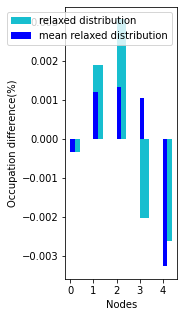

1.4318031112446586e-05


In [36]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.4*N, 5))

ax.bar(nodes, [h/sum(history[0][-1]) - k for h, k in zip(history[0][-1], pSNorm_new)], width=0.4, 
       align='edge', color='tab:cyan', label='relaxed distribution')
ax.bar(nodes, [h - k for h, k in zip(hMean[-1], pSNorm_new)],
       width=0.2, align='edge', color='blue', label='mean relaxed distribution')

ax.legend()
ax.set_xlabel("Nodes")
ax.set_ylabel("Occupation difference(%)")
ax.set_xticks(np.arange(0, N, 1))
# ax.grid(True)

plt.show()

print(sum([np.abs(h - k) for h, k in zip(hMean[-1], pSNorm_new)])/len(history[0]))

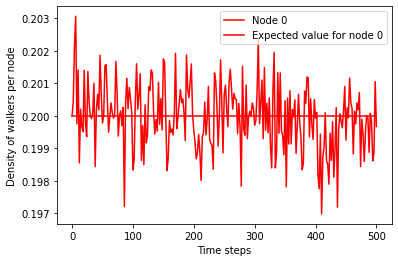

In [37]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
node = [0]
color = ['red', 'orange', 'blue', 'green']

time_range = hMean
index = np.arange(0, len(time_range), 2)

col = 0
for i in node:
    ax.plot(index, [time_range[ind][i] for ind in index], label = f"Node {i}", color = color[col])
    ax.plot(index, [pSNorm_new[i]]*len(index), label = f"Expected value for node {i}", color = color[col])
    col += 1
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Density of walkers per node")
ax.legend()

plt.show()

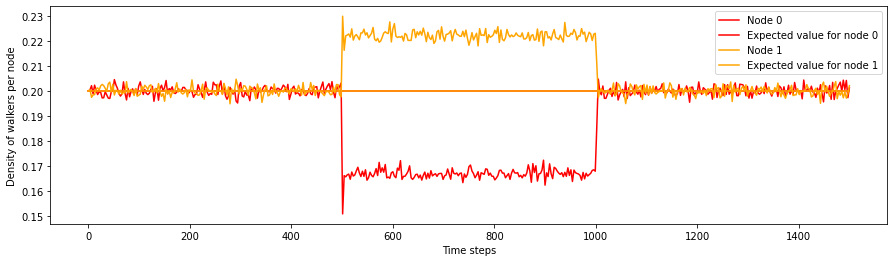

In [38]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15, 4))
node = [0, 1]
color = ['red', 'orange', 'blue', 'green']

time_range = long_history[0]
index = np.arange(0, len(time_range), 3)

col = 0
for i in node:
    ax.plot(index, [time_range[ind][i]/walker_per_node/N for ind in index], label = f"Node {i}", color = color[col])
    ax.plot(index, [pSNorm[i]]*len(index), label = f"Expected value for node {i}", color = color[col])
#     ax.plot(index, [pS2Norm[i]]*len(index), label = f"Perturbed value for node {i}", color = 'yellow')
    
#     index2 = np.arange(2*time_steps, 3*time_steps, 5)
#     ax.plot(index2, [time_range[ind][i]/walker_per_node/N for ind in index2], label = f"Node {i}", color = color[col])

    col += 1
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Density of walkers per node")
ax.legend()

plt.show()